In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import platform
import os
import time

print('Python ver:', platform.python_version())
print('Scikit-learn ver:', sklearn.__version__)
print('Pandas ver:', pd.__version__)
print('Numpy ver:', np.__version__)

Python ver: 3.7.3
Scikit-learn ver: 1.0.2
Pandas ver: 1.3.5
Numpy ver: 1.19.4


In [2]:
# Read csv and check the data
cwd = os.path.dirname(os.path.abspath('__file__'))
dataset_dir = os.path.join(cwd, '..', '..', 'Transformed dataset')
mean_path = os.path.join(dataset_dir, 'transformed_mean.csv')
var_path = os.path.join(dataset_dir, 'transformed_var.csv')

mean_csv = pd.read_csv(mean_path)
var_csv = pd.read_csv(var_path)

In [3]:
mean_csv = mean_csv.drop(columns=["label"])
mean_csv = mean_csv.add_suffix("_mean")
mean_csv.columns = mean_csv.columns.str.replace("Unnamed: 0_mean", "index")
mean_csv.columns

Index(['index', 'xpos_mean', 'ypos_mean', 'zpos_mean', 'xvel_mean',
       'yvel_mean', 'zvel_mean', 'xacc_mean', 'yacc_mean', 'zacc_mean'],
      dtype='object')

In [5]:
mean_csv = mean_csv.drop(['xpos_mean','ypos_mean'], axis=1)
mean_csv.head()

,index,zpos_mean,xvel_mean,yvel_mean,zvel_mean,xacc_mean,yacc_mean,zacc_mean
0,0,1.126524,-0.034340,-0.008131,-0.254972,-0.062188,-0.022162,-0.127762
1,1,1.118971,-0.022590,-0.038763,-0.215774,-0.130912,-0.094322,-0.156462
2,2,1.058666,0.008053,-0.014171,-0.241596,-0.187329,-0.094175,-0.304099
3,3,1.098358,-0.016384,-0.023224,-0.176972,-0.147660,-0.086541,-0.152001
4,4,1.036649,-0.033658,0.015930,-0.182137,-0.022553,0.011463,0.136443


In [4]:
var_csv = var_csv.add_suffix("_var")
var_csv.columns = var_csv.columns.str.replace("Unnamed: 0_var", 'index')
var_csv.columns = var_csv.columns.str.replace("label_var", 'label')
var_csv.columns

Index(['index', 'xpos_var', 'ypos_var', 'zpos_var', 'xvel_var', 'yvel_var',
       'zvel_var', 'xacc_var', 'yacc_var', 'zacc_var', 'label'],
      dtype='object')

In [6]:
var_csv = var_csv.drop(['xpos_var','ypos_var'], axis=1)
var_csv.head()

,index,zpos_var,xvel_var,yvel_var,zvel_var,xacc_var,yacc_var,zacc_var,label
0,0,0.134980,0.010190,0.007413,0.122343,0.010610,0.014236,0.065308,0
1,1,0.081638,0.044725,0.012691,0.232494,0.042590,0.039106,0.189655,0
2,2,0.138591,0.110522,0.009268,0.282040,0.071227,0.039771,0.189879,0
3,3,0.095979,0.042904,0.005863,0.110072,0.039747,0.021820,0.072890,0
4,4,0.073720,0.003504,0.016209,0.186231,0.003395,0.022270,0.218428,0


In [7]:
merged = mean_csv.merge(var_csv, on='index')
merged.columns

Index(['index', 'zpos_mean', 'xvel_mean', 'yvel_mean', 'zvel_mean',
       'xacc_mean', 'yacc_mean', 'zacc_mean', 'zpos_var', 'xvel_var',
       'yvel_var', 'zvel_var', 'xacc_var', 'yacc_var', 'zacc_var', 'label'],
      dtype='object')

In [8]:
merged.head()

,index,zpos_mean,xvel_mean,yvel_mean,zvel_mean,xacc_mean,yacc_mean,zacc_mean,zpos_var,xvel_var,yvel_var,zvel_var,xacc_var,yacc_var,zacc_var,label
0,0,1.126524,-0.034340,-0.008131,-0.254972,-0.062188,-0.022162,-0.127762,0.134980,0.010190,0.007413,0.122343,0.010610,0.014236,0.065308,0
1,1,1.118971,-0.022590,-0.038763,-0.215774,-0.130912,-0.094322,-0.156462,0.081638,0.044725,0.012691,0.232494,0.042590,0.039106,0.189655,0
2,2,1.058666,0.008053,-0.014171,-0.241596,-0.187329,-0.094175,-0.304099,0.138591,0.110522,0.009268,0.282040,0.071227,0.039771,0.189879,0
3,3,1.098358,-0.016384,-0.023224,-0.176972,-0.147660,-0.086541,-0.152001,0.095979,0.042904,0.005863,0.110072,0.039747,0.021820,0.072890,0
4,4,1.036649,-0.033658,0.015930,-0.182137,-0.022553,0.011463,0.136443,0.073720,0.003504,0.016209,0.186231,0.003395,0.022270,0.218428,0


In [9]:
features = merged.drop(['index','label'], axis=1)
features.head()

,zpos_mean,xvel_mean,yvel_mean,zvel_mean,xacc_mean,yacc_mean,zacc_mean,zpos_var,xvel_var,yvel_var,zvel_var,xacc_var,yacc_var,zacc_var
0,1.126524,-0.034340,-0.008131,-0.254972,-0.062188,-0.022162,-0.127762,0.134980,0.010190,0.007413,0.122343,0.010610,0.014236,0.065308
1,1.118971,-0.022590,-0.038763,-0.215774,-0.130912,-0.094322,-0.156462,0.081638,0.044725,0.012691,0.232494,0.042590,0.039106,0.189655
2,1.058666,0.008053,-0.014171,-0.241596,-0.187329,-0.094175,-0.304099,0.138591,0.110522,0.009268,0.282040,0.071227,0.039771,0.189879
3,1.098358,-0.016384,-0.023224,-0.176972,-0.147660,-0.086541,-0.152001,0.095979,0.042904,0.005863,0.110072,0.039747,0.021820,0.072890
4,1.036649,-0.033658,0.015930,-0.182137,-0.022553,0.011463,0.136443,0.073720,0.003504,0.016209,0.186231,0.003395,0.022270,0.218428


In [10]:
X = features.values
Y = merged['label'].values
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [11]:
model_to_evaluate = []
model_to_evaluate.append(('KNN', KNeighborsClassifier(), 'K-nearest Neighbor'))
model_to_evaluate.append(('DT', DecisionTreeClassifier(), 'DecisionTree'))
model_to_evaluate.append(('NB', GaussianNB(), 'Gaussian Naive-Bayes'))
model_to_evaluate.append(('SVM', SVC(), 'Support Vector Machine'))

In [12]:
results=[]
names=[]

for name, model, full_name in model_to_evaluate:
    kfold = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)
    cv_result = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    results.append(cv_result)
    names.append(name)
    print(f'Akurasi {name}: {cv_result.mean()} dengan std dev {cv_result.std()}')
    print()

Akurasi KNN: 0.9693043651584613 dengan std dev 0.027469380936381477

Akurasi DT: 0.9539011804309792 dengan std dev 0.020370179183532167

Akurasi NB: 0.9327619427280579 dengan std dev 0.026565176062387477

Akurasi SVM: 0.9750736385179278 dengan std dev 0.02707655359935196



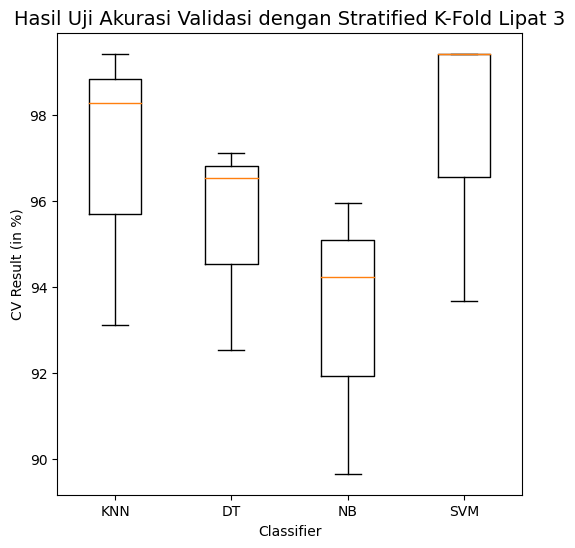

In [13]:
plt.figure(figsize=(6,6))
plt.boxplot(list(map(lambda item: item*100, results)), labels=names)
plt.title('Hasil Uji Akurasi Validasi dengan Stratified K-Fold Lipat 3', fontdict={'fontweight': 'normal', 'fontsize':'14'})
plt.xlabel('Classifier')
plt.ylabel('CV Result (in %)')
# plt.savefig('CV Result.png', dpi=300)
plt.show()


In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.10, random_state=1)

In [15]:
plot_label = ['Tidak Jatuh', 'Jatuh']

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        38
           1       1.00      0.86      0.92        14

    accuracy                           0.96        52
   macro avg       0.97      0.93      0.95        52
weighted avg       0.96      0.96      0.96        52

              precision    recall  f1-score   support

           0       0.90      0.97      0.94        38
           1       0.91      0.71      0.80        14

    accuracy                           0.90        52
   macro avg       0.91      0.84      0.87        52
weighted avg       0.90      0.90      0.90        52

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        38
           1       0.87      0.93      0.90        14

    accuracy                           0.94        52
   macro avg       0.92      0.94      0.93        52
weighted avg       0.94      0.94      0.94        52

              preci

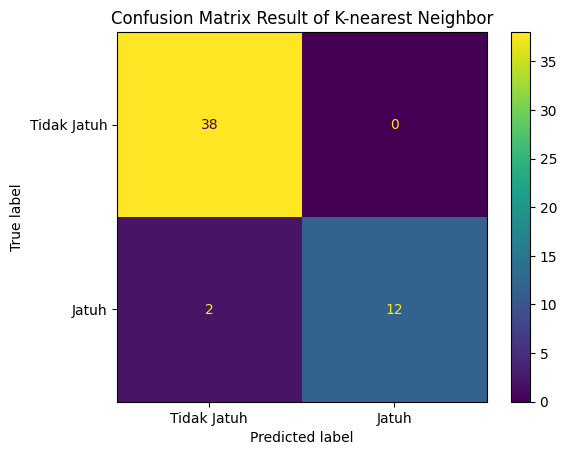

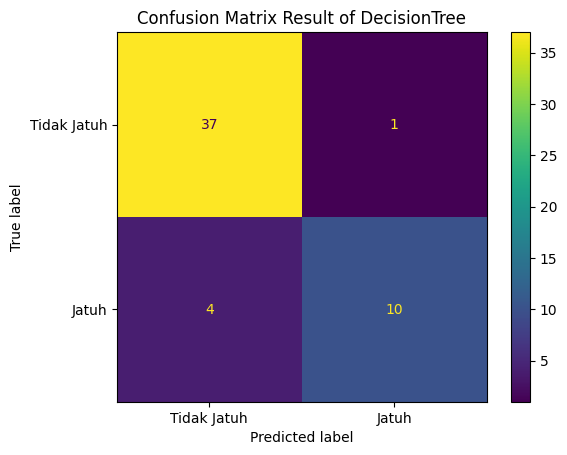

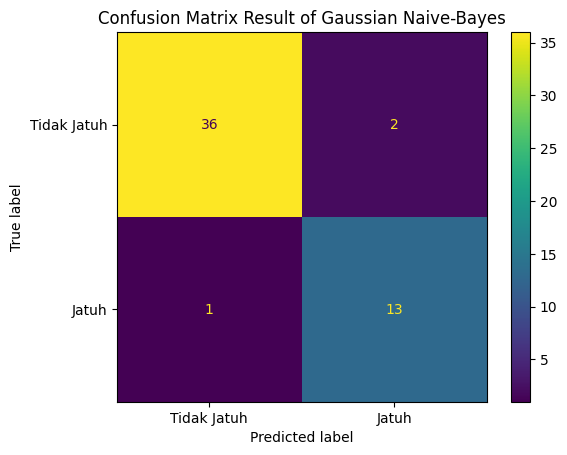

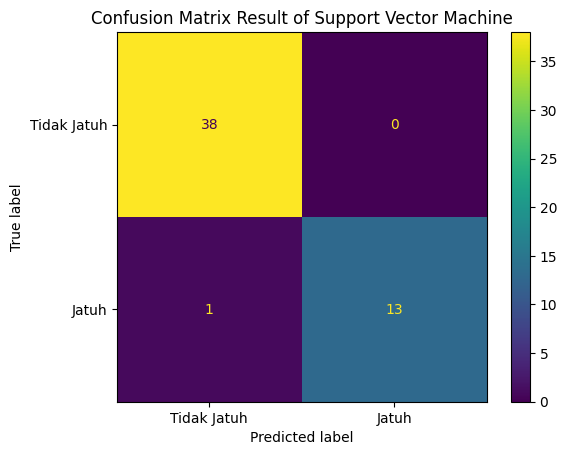

In [16]:
for name, model, full_name in model_to_evaluate:
    clf = model
    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_val)
    print(classification_report(Y_val, predictions))
    disp = ConfusionMatrixDisplay.from_predictions(Y_val, predictions, display_labels=plot_label)
    disp.ax_.set_title(f'Confusion Matrix Result of {full_name}')